In [1]:
from bs4 import BeautifulSoup
import requests
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'}

import pickle
import os
import pandas as pd
import matplotlib.pyplot as plt
import geopandas
import seaborn as sns
plt.style.use('ggplot')
import plotly.express as px


import warnings
warnings.filterwarnings('ignore')

In [ ]:
main_url = 'https://locations.chipotle.com/'

html = requests.get(main_url, headers).content
soup = BeautifulSoup(html, 'html.parser')
states = {e.text: 'https://locations.chipotle.com/' + e['href'] for e in soup.select('ul.x a')}

addresses = []
for state, state_url in states.items():
    
    state_html = requests.get(state_url, headers).content
    state_soup = BeautifulSoup(state_html, 'html.parser')
    cities = {e.text: 'https://locations.chipotle.com/' + e['href'] for e in state_soup.select('ul.x a')}

    for city, city_url in cities.items():
        city_html = requests.get(city_url, headers).content
        city_soup = BeautifulSoup(city_html, 'html.parser')
        
        location_urls = ['https://locations.chipotle.com/' + e['href'] for e in city_soup.select('div.x li.x a.x')]
        
        if len(location_urls) > 0:
            for location_url in location_urls:
                location_html = requests.get(location_url, headers).content
                location_soup = BeautifulSoup(location_html, 'html.parser')
                try:
                    address = location_soup.select_one('div.Core-address').text
                except:
                    address = None
                addresses.append(address)
        else:
            try:
                address = city_soup.select_one('div.Core-address').text
            except:
                address = None
            addresses.append(address)

        print(f'{state}, {city}, {len(set(addresses))}'.ljust(100), end='\r')


In [2]:
#pickle.dump(addresses, open('chipotle_addresses.pickle','wb'))

In [ ]:
main_url = 'https://locations.tacobell.com/'

html = requests.get(main_url, headers).content
soup = BeautifulSoup(html, 'html.parser')
states = {e.text: 'https://locations.tacobell.com/' + e['href'] for e in soup.select('div[class="x"] a[class="x"]')}

addresses = []
for state, state_url in states.items():
    
    state_html = requests.get(state_url, headers).content
    state_soup = BeautifulSoup(state_html, 'html.parser')
    cities = {e.text: 'https://locations.tacobell.com/' + e['href'] for e in state_soup.select('div[class="x"] a[class="x"]')}

    for city, city_url in cities.items():
        city_html = requests.get(city_url, headers).content
        city_soup = BeautifulSoup(city_html, 'html.parser')

        locations=[e.text for e in city_soup.select('div[class="x"] a[class="x"]')]
        addresses.extend(locations)

        print(f'{state}, {city}, {len(set(addresses))}'.ljust(100), end='\r')

In [3]:
#pickle.dump(addresses, open('tacobell_addresses.pickle','wb'))

In [4]:
tacobell_addresses=pickle.load(open('tacobell_addresses.pickle','rb'))
chipotle_addresses=pickle.load(open('chipotle_addresses.pickle','rb'))

In [5]:
all_addresses=[]

for i in tacobell_addresses:
    all_addresses.append({'Restaurant':'Taco Bell','Address':i})

for i in chipotle_addresses:
    all_addresses.append({'Restaurant':'Chipotle','Address':i})

In [6]:
df=pd.DataFrame(all_addresses)

In [7]:
states=df['Address'].apply(lambda x:x.split(',')[-1].strip().split(' ')[0].strip())
zips=df['Address'].apply(lambda x:x.split(',')[-1].strip().split(' ')[1].strip())
cities=df['Address'].apply(lambda x:x.split(',')[0].strip().split(' ')[-1].strip())


df['State']=states
df['City']=cities
df['Zip Code']=zips

df=df.drop(columns='Address')

In [8]:
df

,Restaurant,State,City,Zip Code
0,Taco Bell,AK,Anchorage,99515
1,Taco Bell,AK,Anchorage,99507
2,Taco Bell,AK,Anchorage,99501
3,Taco Bell,AK,Anchorage,99507
4,Taco Bell,AK,Anchorage,99503
...,...,...,...,...
11741,Chipotle,WI,Prairie,53158
11742,Chipotle,WI,Wauwatosa,53222
11743,Chipotle,WI,Bend,53095
11744,Chipotle,WY,Cheyenne,82009


### Cities DF

In [9]:
import kagglehub

path = kagglehub.dataset_download("juanmah/world-cities")

cities=pd.read_csv(os.path.join(path,'worldcities.csv'))

In [10]:
cities=cities[cities['iso3']=='USA']
cities=cities.sort_values('population',ascending=False)
cities=cities.drop_duplicates(subset='city',keep='first')

### States and Zip Codes DF

In [11]:
states=geopandas.read_file(r'C:\Users\berid\python\geopandas\USA States\s_22mr22.shp')

In [12]:
zip_codes=geopandas.read_file(r'C:\Users\berid\python\geopandas\USA Zip Codes\tl_2019_us_zcta510.shp')

In [13]:
zip_codes['Zip Lon']=zip_codes['geometry'].centroid.x
zip_codes['Zip Lat']=zip_codes['geometry'].centroid.y

##### Merging

In [14]:
df=df.merge(zip_codes[['GEOID10','Zip Lon', 'Zip Lat']], left_on='Zip Code', right_on='GEOID10', how='left').drop(columns='GEOID10')

In [15]:
df=df.merge(cities[['city','lat','lng']], left_on='City', right_on='city', how='left').drop(columns='city').rename(columns={'lat':'City Lat', 'lng':'City Lon'})

In [16]:
df

,Restaurant,State,City,Zip Code,Zip Lon,Zip Lat,City Lat,City Lon
0,Taco Bell,AK,Anchorage,99515,-149.891987,61.116386,61.1508,-149.1091
1,Taco Bell,AK,Anchorage,99507,-149.775973,61.149745,61.1508,-149.1091
2,Taco Bell,AK,Anchorage,99501,-149.856566,61.220262,61.1508,-149.1091
3,Taco Bell,AK,Anchorage,99507,-149.775973,61.149745,61.1508,-149.1091
4,Taco Bell,AK,Anchorage,99503,-156.857497,61.908005,61.1508,-149.1091
...,...,...,...,...,...,...,...,...
11741,Chipotle,WI,Prairie,53158,-87.885515,42.524342,NaN,NaN
11742,Chipotle,WI,Wauwatosa,53222,-88.035525,43.082416,43.0616,-88.0347
11743,Chipotle,WI,Bend,53095,-88.157874,43.389034,44.0563,-121.3095
11744,Chipotle,WY,Cheyenne,82009,-104.848671,41.377990,41.1350,-104.7902


# EDA

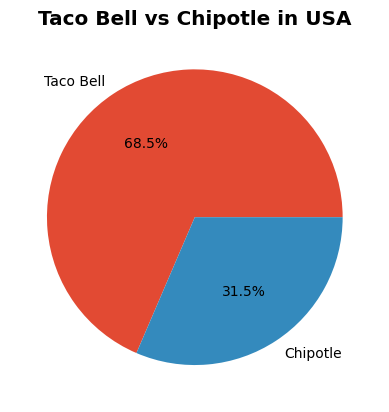

In [17]:
df['Restaurant'].value_counts().plot.pie(autopct='%.1f%%')
plt.title('Taco Bell vs Chipotle in USA', fontweight='bold')
plt.ylabel('')
plt.show()


In [42]:
fig = px.density_mapbox(
    cities,
    lat='lat',
    lon='lng',
    z=pd.qcut(cities['population'], q=10, labels=False),
    radius=10,
    zoom=3,
    color_continuous_scale='Greys',
    opacity=1
)

scatter_1 = px.scatter_mapbox(df[df['Restaurant']=='Chipotle'], lat='Zip Lat', lon='Zip Lon', color='Restaurant', zoom=3,opacity=1)
scatter_1.update_traces(marker=dict(size=10, color='Red'))
scatter_2 = px.scatter_mapbox(df[df['Restaurant']=='Taco Bell'], lat='Zip Lat', lon='Zip Lon', color='Restaurant', zoom=3,opacity=1)
scatter_2.update_traces(marker=dict(size=5, color='Blue'))

for trace in scatter_1.data:
    trace.update(marker=dict(coloraxis=None))
    fig.add_trace(trace)

for trace in scatter_2.data:
    trace.update(marker=dict(coloraxis=None))
    fig.add_trace(trace)


fig.update_layout(
    mapbox_style='open-street-map',
    height=700,
    width=1500,
    margin=dict(l=0, r=0, t=0, b=0),
    showlegend=True
)

fig.update_layout(coloraxis_showscale=False)
fig.show()


In [19]:
grouped=df.groupby(['State','Restaurant']).size().reset_index(name='Count')
grouped['Share']=grouped.groupby('State')['Count'].transform(lambda x : x/x.sum())
grouped=grouped.sort_values(['Restaurant','Share'],ascending=[False, False])

fig=px.bar(grouped, x='State', y='Share',color='Restaurant',text=grouped['Share'].round(2))

fig.update_layout(
    mapbox_style='open-street-map',
    showlegend=True
)

fig.update_layout(title=dict(text='Chipotle vs Taco Bell Share by State'))

In [ ]:
common_zips=[]
for zip in df[df['Restaurant']=='Taco Bell']['Zip Code'].unique():
    if zip in df[df['Restaurant']=='Chipotle']['Zip Code'].unique():
        common_zips.append(zip)
len(common_zips)

#there are 2277 zip codes across the USA, where both restaurants are present

2277

In [ ]:
#df.to_csv('Chipotle vs Taco Bell.csv',index=False)